In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from tensorflow.keras.backend import mean
from tensorflow.keras.backend import square
from tensorflow.keras.backend import variable
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow import expand_dims
from tensorflow import Session
import numpy as np
import pickle
from scipy.stats import zscore
import datetime
import pytz

In [2]:
y_in = Input(shape=(512,1))
y_err = Input(shape=(512,1))
# h_enc = Conv1D(32, 2, activation='relu')(y_in)
# h_enc = Conv1D(32, 8, activation='relu')(h_enc)
# h_enc = CuDNNGRU(512, return_sequences=True)(y_in)
# h_enc = CuDNNGRU(256, return_sequences=True)(y_in)
h_enc = CuDNNLSTM(1024, return_sequences=False)(y_in)
# h_enc = BatchNormalization()(h_enc)
h_enc = Dense(16, activation=None, name='bottleneck')(h_enc)
# h_enc = BatchNormalization()(h_enc)
h_dec = RepeatVector(512)(h_enc)
h_dec = CuDNNLSTM(1024, return_sequences=True)(h_dec)
# h_dec = CuDNNGRU(256, return_sequences=True)(h_dec)
h_dec = TimeDistributed(Dense(1))(h_dec)
model = Model(inputs=[y_in, y_err], outputs=h_dec)

model.load_weights("../../model_weights/model_2020-02-09_10-36-06.h5")


In [97]:
with open('../../../data_GRS1915/95921_len512_s40_counts.pkl', 'rb') as f:
    segments = pickle.load(f)
with open('../../../data_GRS1915/95921_len512_s40_errors.pkl', 'rb') as f:
    errors = pickle.load(f)
with open('../../../data_GRS1915/95921_len512_s40_ids.pkl', 'rb') as f:
    seg_ids = pickle.load(f)

In [98]:
seg_ids

['30183-02-02-00',
 '90105-07-02-00',
 '93701-01-11-01',
 '60100-01-02-000',
 '10408-01-44-00',
 '90024-02-34-00',
 '20402-01-49-00',
 '90701-01-32-00',
 '30402-01-12-03',
 '50703-01-14-02',
 '50125-01-04-00',
 '20402-01-60-00',
 '90108-01-01-00',
 '20186-03-02-050',
 '30182-01-02-00',
 '30182-01-03-00',
 '91701-01-79-00',
 '50125-01-01-02',
 '40116-01-03-00',
 '20186-03-02-050',
 '20402-01-25-00',
 '10408-01-43-00',
 '50703-01-35-01',
 '90105-02-02-00',
 '70702-01-55-00',
 '96701-01-24-00',
 '50703-01-29-00',
 '60405-01-02-00',
 '60100-01-02-000',
 '40703-01-33-02',
 '70702-01-37-00',
 '40703-01-32-00',
 '50703-01-46-01',
 '50405-01-02-00',
 '60701-01-16-01',
 '20186-03-02-000',
 '20186-03-02-04',
 '60100-01-01-000',
 '40703-01-13-01',
 '10408-01-07-00',
 '94701-01-35-00',
 '30703-01-06-00',
 '70702-01-44-01',
 '20186-03-02-01',
 '20402-01-45-00',
 '60701-01-28-00',
 '50703-01-12-03',
 '40703-01-04-00',
 '90105-06-03-00',
 '10408-01-15-01',
 '90701-01-36-01',
 '30703-01-13-00',
 '4070

In [4]:
global_mean = np.mean(segments)
global_std = np.std(segments)
print(global_mean, global_std)

2446.8107556038954 1435.9368424377972


In [5]:
errors = ((errors)/np.std(segments)).astype(np.float32)
segments = zscore(segments, axis=None).astype(np.float32)  # standardize

In [58]:
reconstructions = np.zeros((95921, 512))
for segment_index, segment in enumerate(segments):
    reconstructions[segment_index] = model.predict([np.expand_dims(segment, axis=0), np.expand_dims(errors[segment_index], axis=0)]).flatten()

In [3]:
# np.savetxt("../../model_2020-02-09_10-36-06_reconstructions.csv", reconstructions, delimiter=",")

NameError: name 'reconstructions' is not defined

In [64]:
chi2_series_wise = []
for reco_ind, reco in enumerate(reconstructions):
    chi2_series_wise.append(np.mean(np.square(segments[reco_ind]-reco)/np.square(errors[reco_ind])))
    print(reco_ind)
    clear_output(wait=True)

95920


In [67]:
np.mean(chi2_series_wise)

45.19255549492725

(array([6.0094e+04, 4.9680e+03, 6.4670e+03, 5.1470e+03, 3.6790e+03,
        2.2520e+03, 1.7250e+03, 1.3770e+03, 1.2310e+03, 1.1540e+03,
        9.5700e+02, 9.8300e+02, 1.0250e+03, 7.7500e+02, 6.1600e+02,
        4.9600e+02, 4.2000e+02, 2.8700e+02, 2.5000e+02, 2.1400e+02,
        1.8400e+02, 1.6600e+02, 1.2200e+02, 1.3200e+02, 9.8000e+01,
        8.8000e+01, 6.9000e+01, 5.5000e+01, 5.4000e+01, 5.3000e+01,
        6.1000e+01, 5.5000e+01, 4.3000e+01, 4.1000e+01, 4.0000e+01,
        4.3000e+01, 3.1000e+01, 3.5000e+01, 2.4000e+01, 2.5000e+01,
        2.8000e+01, 4.1000e+01, 2.6000e+01, 3.2000e+01, 2.2000e+01,
        2.6000e+01, 1.9000e+01, 1.8000e+01, 1.9000e+01, 1.3000e+01,
        1.3000e+01, 1.0000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        6.0000e+00, 9.0000e+00, 8.0000e+00, 4.0000e+00, 6.0000e+00,
        4.0000e+00, 6.0000e+00, 6.0000e+00, 5.0000e+00, 6.0000e+00,
        5.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 2.00

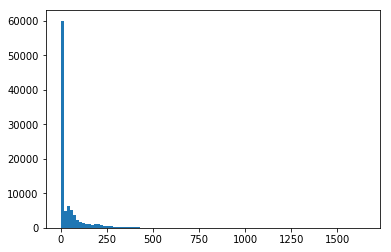

In [66]:
plt.hist(chi2_series_wise,bins=100)

In [29]:
reconstructions = np.loadtxt("../../model_2020-02-09_10-36-06_reconstructions.csv", delimiter=",")

In [30]:
reconstructions[0]

array([-0.52600116, -0.52780372, -0.52736789, -0.53070855, -0.51268762,
       -0.52057785, -0.52133554, -0.52509373, -0.52573085, -0.53118271,
       -0.52730757, -0.53469849, -0.53862303, -0.53782171, -0.5413664 ,
       -0.53852737, -0.54283369, -0.54097921, -0.54058164, -0.54298294,
       -0.54188013, -0.53899854, -0.54408884, -0.54164886, -0.54488593,
       -0.54533255, -0.54156291, -0.54567599, -0.5405187 , -0.54302162,
       -0.54108316, -0.53807133, -0.54003364, -0.53466225, -0.53440082,
       -0.53161353, -0.52995431, -0.52926886, -0.52770019, -0.52703428,
       -0.5257616 , -0.52479976, -0.52378076, -0.52242321, -0.52021855,
       -0.51505142, -0.51956052, -0.51801884, -0.51984662, -0.51964641,
       -0.51906961, -0.51748908, -0.51666415, -0.51649761, -0.51556343,
       -0.51554435, -0.51509005, -0.51461577, -0.51523441, -0.51575738,
       -0.51219028, -0.50548565, -0.51367724, -0.51040989, -0.51139885,
       -0.51399684, -0.51142645, -0.51394278, -0.51231837, -0.51

In [32]:
n=0

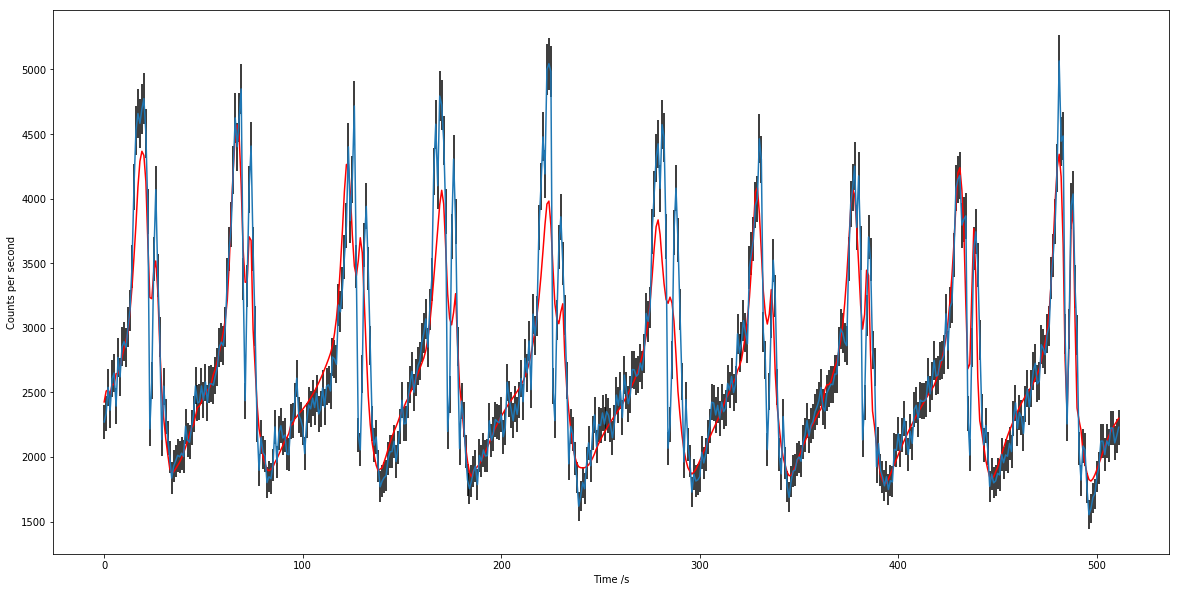

In [70]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

plt.errorbar(y=segments[n],x=list(range(512)), yerr=errors[n], ecolor="black")
plt.plot(reconstructions[n]*1435.9368424377972+2446.8107556038954, c="r")
plt.xlabel("Time /s")
plt.ylabel("Counts per second")
plt.show()
n+=1

In [10]:
from IPython.display import clear_output
model.layers[:3]

In [ ]:
embeddings = np.zeros((95921, 16))
encoder = Sequential(model.layers[:3])
for segment_index, segment in enumerate(segments):
    embeddings[segment_index] = encoder.predict(np.expand_dims(segment, axis=0)).flatten()
    print(segment_index)
    clear_output(wait=True)

2029


In [ ]:

for batch in range(0, int(375*256), 256)

In [8]:
list(range(0, int(375*256), 256))

[0,
 256,
 512,
 768,
 1024,
 1280,
 1536,
 1792,
 2048,
 2304,
 2560,
 2816,
 3072,
 3328,
 3584,
 3840,
 4096,
 4352,
 4608,
 4864,
 5120,
 5376,
 5632,
 5888,
 6144,
 6400,
 6656,
 6912,
 7168,
 7424,
 7680,
 7936,
 8192,
 8448,
 8704,
 8960,
 9216,
 9472,
 9728,
 9984,
 10240,
 10496,
 10752,
 11008,
 11264,
 11520,
 11776,
 12032,
 12288,
 12544,
 12800,
 13056,
 13312,
 13568,
 13824,
 14080,
 14336,
 14592,
 14848,
 15104,
 15360,
 15616,
 15872,
 16128,
 16384,
 16640,
 16896,
 17152,
 17408,
 17664,
 17920,
 18176,
 18432,
 18688,
 18944,
 19200,
 19456,
 19712,
 19968,
 20224,
 20480,
 20736,
 20992,
 21248,
 21504,
 21760,
 22016,
 22272,
 22528,
 22784,
 23040,
 23296,
 23552,
 23808,
 24064,
 24320,
 24576,
 24832,
 25088,
 25344,
 25600,
 25856,
 26112,
 26368,
 26624,
 26880,
 27136,
 27392,
 27648,
 27904,
 28160,
 28416,
 28672,
 28928,
 29184,
 29440,
 29696,
 29952,
 30208,
 30464,
 30720,
 30976,
 31232,
 31488,
 31744,
 32000,
 32256,
 32512,
 32768,
 33024,
 33280

# Generate light curve segments from arbitrary points in the latent space

In [ ]:
# np.savetxt("../../model_2020-02-09_10-36-06_embeddings.csv", embeddings, delimiter=",")

In [18]:
import numpy as np
embeddings = np.loadtxt("../../../data_GRS1915/model_2020-02-09_10-36-06_embeddings.csv", delimiter=",")

In [ ]:
# ponly the pre-release umap version has inverse-transform implemented; pip install --pre umap-learn
# but this uses up all of ram
import umap
UMAP_mapper = umap.UMAP(n_neighbors=50, min_dist=0.0)
UMAP_mapper.fit(embeddings)

In [ ]:
# import pickle
# with open('../../../data_GRS1915/model_2020-02-09_10-36-06_UMAP_mapper.pkl', 'wb') as f:
#     pickle.dump(UMAP_mapper, f)

In [19]:
import umap
import pickle
with open('../../../data_GRS1915/model_2020-02-09_10-36-06_UMAP_mapper.pkl', 'rb') as f:
    UMAP_mapper = pickle.load(f)

In [20]:
umapembed = UMAP_mapper.transform(embeddings)

In [21]:
embeddings.shape

(95921, 16)

In [13]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

X = np.random.rand(100, 1000)
xs = np.mean(X, axis=1)
ys = np.std(X, axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('click on point to plot time series')
line, = ax.plot(xs, ys, 'o', picker=5)  # 5 points tolerance


# def onpick(event):

#     if event.artist!=line: return True

#     N = len(event.ind)
#     if not N: return True


#     figi = plt.figure()
#     for subplotnum, dataind in enumerate(event.ind):
#         ax = figi.add_subplot(N,1,subplotnum+1)
#         ax.plot(X[dataind])
#         ax.text(0.05, 0.9, 'mu=%1.3f\nsigma=%1.3f'%(xs[dataind], ys[dataind]),
#                 transform=ax.transAxes, va='top')
#         ax.set_ylim(-0.5, 1.5)
#     figi.show()
#     return True

# fig.canvas.mpl_connect('pick_event', onpick)

plt.show()

<IPython.core.display.Javascript object>

In [6]:
x_latent_point = np.linspace(np.min(umapembed[:,0]), np.max(umapembed[:,0]), num=10)
y_latent_point = np.linspace(np.min(umapembed[:,1]), np.max(umapembed[:,1]), num=10)

In [7]:
import itertools
probe_coords = np.array(list(itertools.product(x_latent_point, y_latent_point)))

In [11]:
UMAP_mapper.output_metric='euclidean'
UMAP_mapper._output_metric_kwds = {}

In [12]:
inverse_transformed_points = UMAP_mapper.inverse_transform(probe_coords)

AttributeError: 'UMAP' object has no attribute '_sigmas'

In [34]:
UMAP_mapper

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.0, n_components=2, n_epochs=None,
   n_neighbors=50, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

# Try PCA on the embeddings

In [14]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(embeddings)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

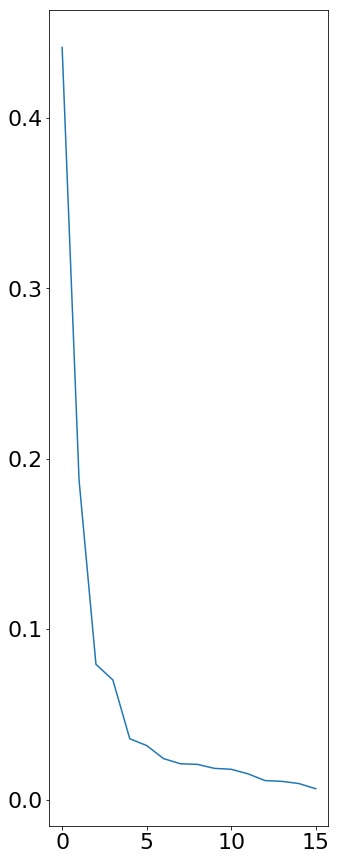

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 15.0)
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [32]:
sum(pca.explained_variance_ratio_[:3])

0.7082544963972677

In [15]:
embed_pca = pca.transform(embeddings)

In [16]:
axs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e9b869320>,
      dtype=object)

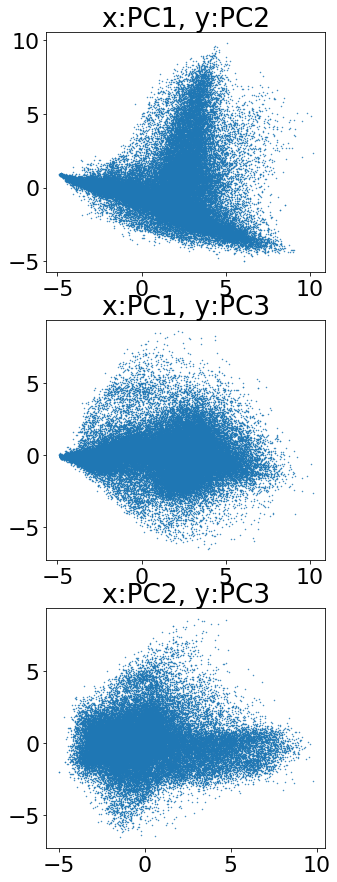

In [21]:
fig, axs = plt.subplots(3)
axs[0].scatter(embed_pca[:,0],embed_pca[:,1], s=0.2)
axs[1].scatter(embed_pca[:,0],embed_pca[:,2], s=0.2)
axs[2].scatter(embed_pca[:,1],embed_pca[:,2], s=0.2)

axs[0].set_title("x:PC1, y:PC2")
axs[1].set_title("x:PC1, y:PC3")
axs[2].set_title("x:PC2, y:PC3")


plt.show()

# Make a coloured plot for every class

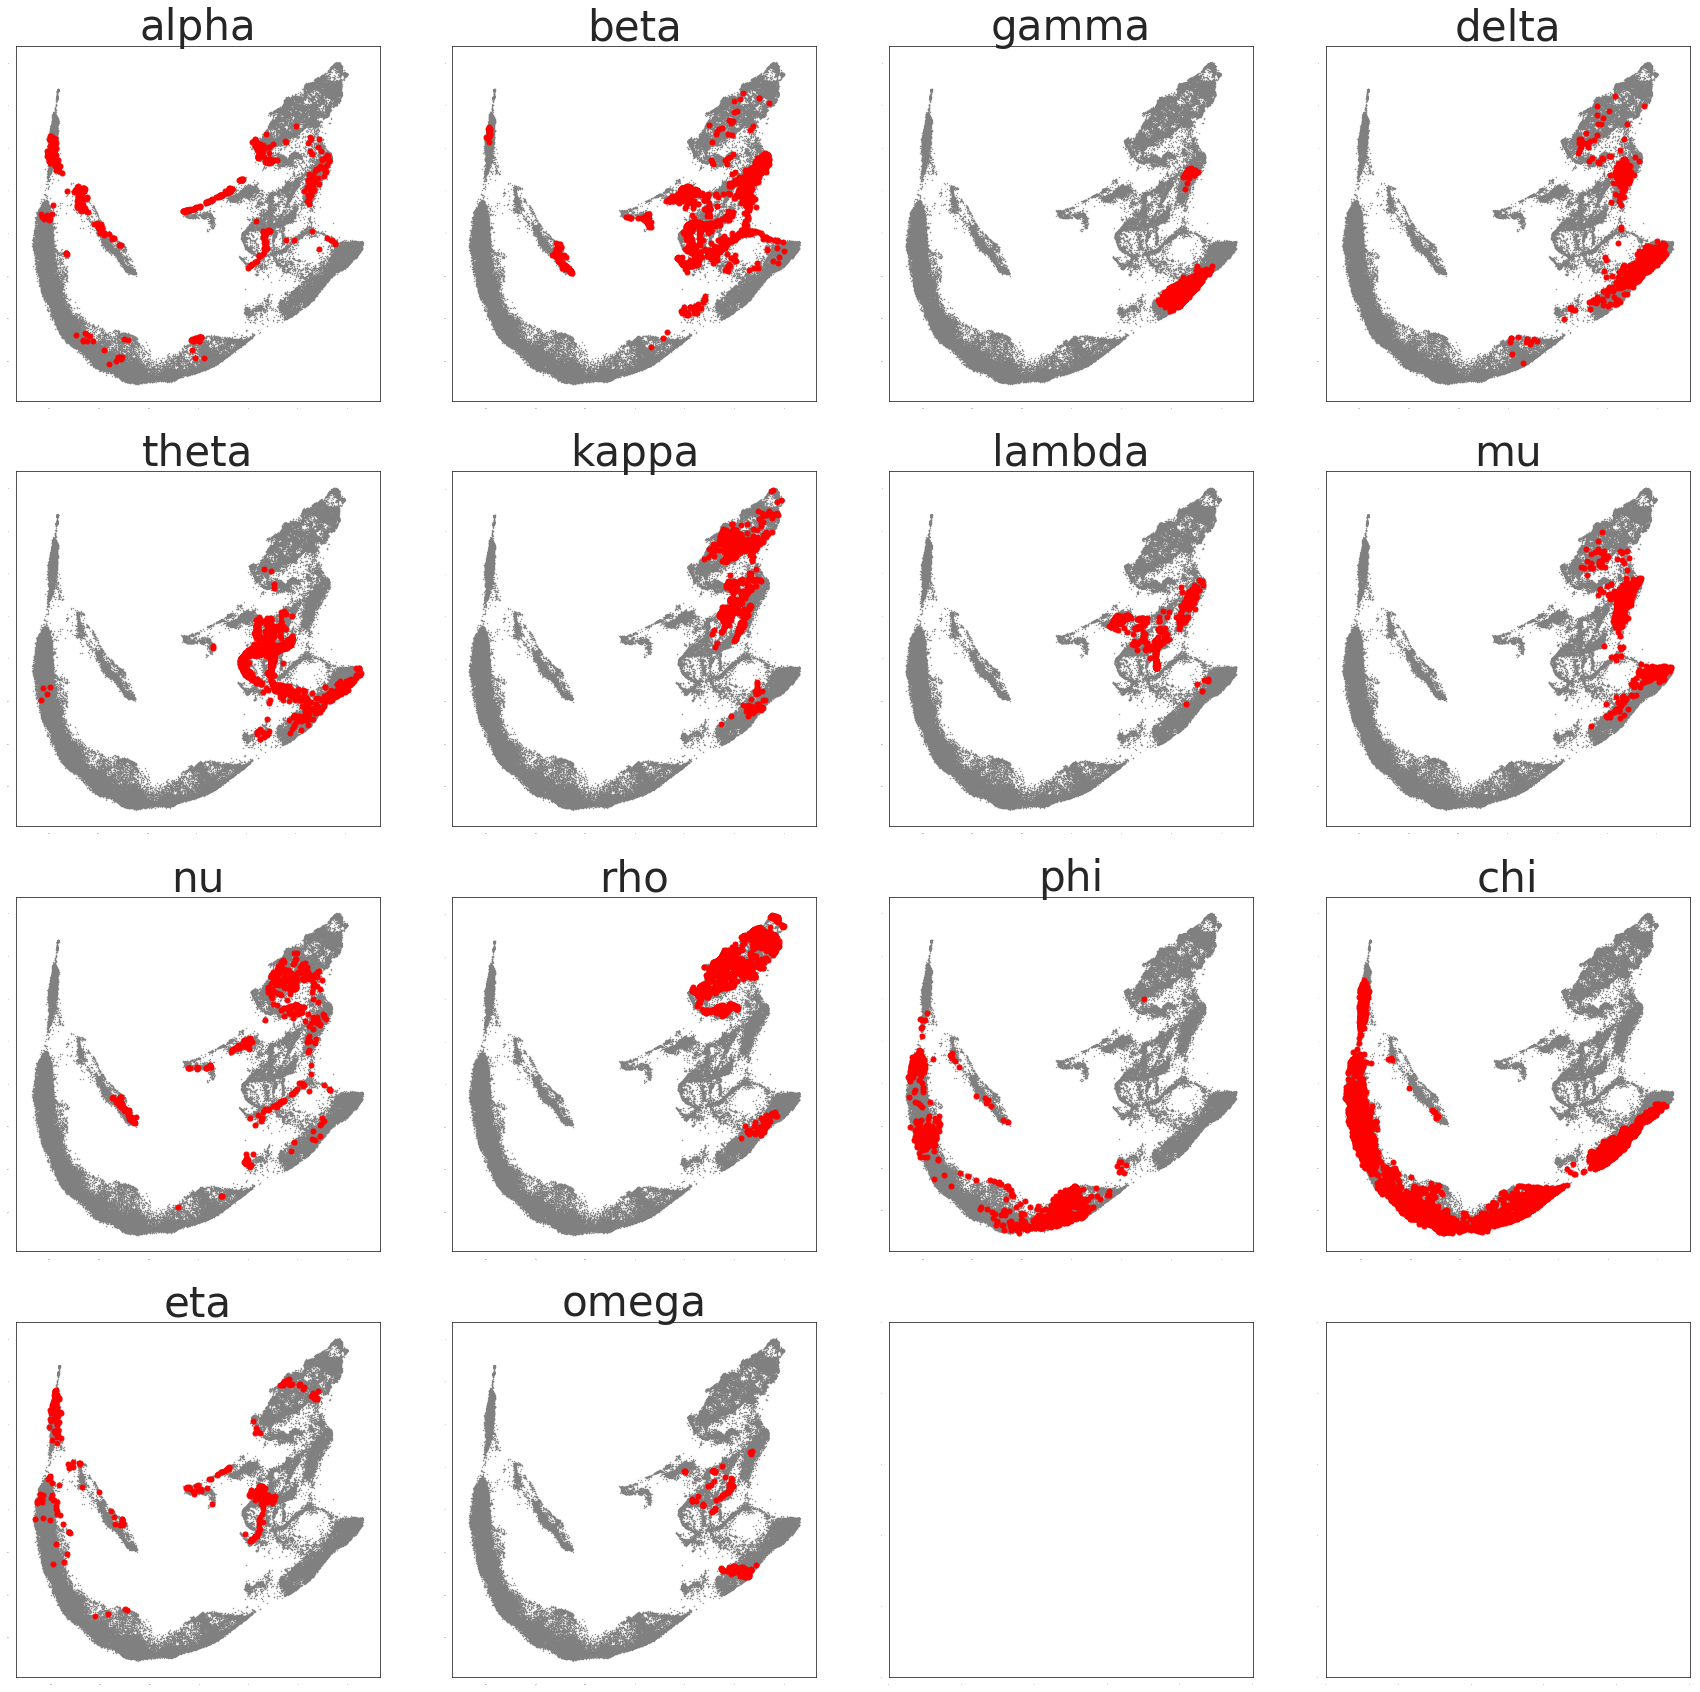

In [28]:
# load observation classifications from Huppenkothen 2017
%matplotlib inline


clean_belloni = open('../../../data_GRS1915/1915Belloniclass_updated.dat')
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state
        
# load segmented light curves

import pickle
# with open('../../../data_GRS1915/95921_len512_s40_counts.pkl', 'rb') as f:
#     segments = pickle.load(f)
# with open('../../../data_GRS1915/95921_len512_s40_errors.pkl', 'rb') as f:
#     errors = pickle.load(f)
# with open('../../../data_GRS1915/95921_len512_s40_ids.pkl', 'rb') as f:
#     seg_ids = pickle.load(f)






# # HF QPO observation ids
# paper_obIDs = np.loadtxt("../../../data_GRS1915/Belloni_Altamirano_obsIDs.txt", dtype=str)

# qpo_colours = []

# for seg_id in seg_ids:
#     if seg_id.split("_")[0] in paper_obIDs:
#         qpo_colours.append("red")
#     else:
#         qpo_colours.append("grey")
        
# qpo_labels = []

# for seg_id in seg_ids:
#     if seg_id.split("_")[0] in paper_obIDs:
#         qpo_labels.append("QPO")
#     else:
#         qpo_labels.append("other")
        
        
# qpo_scales = []

# for seg_id in seg_ids:
#     if seg_id.split("_")[0] in paper_obIDs:
#         qpo_scales.append("QPO")
#     else:
#         qpo_scales.append("other")
        
        
xxx = [seg.split("_")[0] for seg in seg_ids]

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
class_colour = []
for ob in xxx:
    if ob in ob_state:
        class_colour.append(np.where(classes == ob_state[ob])[0][0])
    else:
        class_colour.append(15)
        
classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
class_name = []
for ob in xxx:
    if ob in ob_state:
        class_name.append(ob_state[ob])
        scales.append(5)
    else:
        class_name.append("Unknown")
        scales.append(0.1)
        
        
from matplotlib import cm
cm.get_cmap(plt.get_cmap("Set1"))


colours = ['#ffd8b1', '#000075', '#808080', '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#000000']

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
plt.rcParams['figure.figsize'] = (30.0, 30.0)
plt.rcParams.update({'font.size': 0})

embeddings_lap = umapembed

# fig, ax = plt.subplots()

fig, axs = plt.subplots(4, 4)
axs = axs.flatten()

for plot_class_ind, plot_class in enumerate(classes):
    class_indices = np.where(np.array(class_name) == "Unknown")[0]
    class_data = embeddings_lap[class_indices]
    axs[plot_class_ind].scatter(class_data[:,0], class_data[:,1], s = 0.2, c="grey", label="Unknown")

    class_indices = np.where(np.array(class_name) == plot_class)[0]
    class_data = embeddings_lap[class_indices]
    
    axs[plot_class_ind].scatter(class_data[:,0], class_data[:,1], s = 25, c='red', label=plot_class)
    
# plt.legend()
    axs[plot_class_ind].set_title("{}".format(plot_class), fontsize=42)
axs.reshape((4,4))
# plt.savefig("UMAP_embedding_separate_classes_model_2020-02-09_10-36-06.png")
plt.show()


# redint = np.where(np.array(qpo_colours) == "red")
# greyint= np.where(np.array(qpo_colours) != "red")
# plt.scatter(embeddings_lap[:,0][greyint], embeddings_lap[:,1][greyint], s=1, c="grey", label= "other")
# plt.scatter(embeddings_lap[:,0][redint], embeddings_lap[:,1][redint], s=1, c="red", label= "HF QPO")
# plt.title("UMAP embedding of the encoded GRS1915 segments, neighbors=50, min_dist=0.0, components=2", fontsize=12)
# plt.legend()
# plt.savefig("Belloni_Altamirano_2013_embedded.png")
plt.show()

In [ ]:
# https://matplotlib.org/users/event_handling.html

In [48]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams.update({'font.size': 12})
class_indices = np.where(np.array(class_name) == "rho")
class_data = embeddings_lap[class_indices]
x_segs = segments[class_indices]
top_rho = x_segs[class_data[:,1]>2]
bottom_rho = x_segs[class_data[:,1]<2]


In [41]:
class_data[class_data[:,1]>2]

array([[6.919637 , 6.5689893],
       [6.3020883, 7.0899415],
       [6.241895 , 6.9134264],
       ...,
       [6.870199 , 6.9720225],
       [4.843866 , 5.788953 ],
       [6.001394 , 5.08757  ]], dtype=float32)

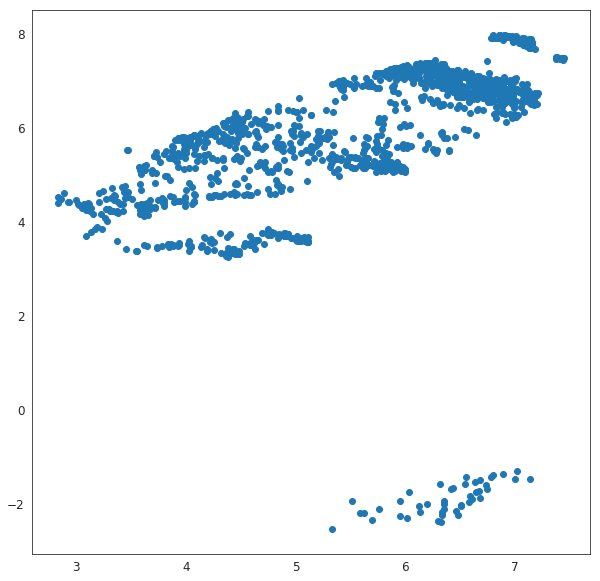

In [38]:
plt.scatter(class_data[:,0], class_data[:,1])
plt.show()

In [35]:
class_indices = np.where(np.array(class_name) == "rho")
class_data = embeddings_lap[class_indices]
np.array(seg_ids)[class_indices]

array(['20402-01-34-00', '20402-01-31-02', '40703-01-07-00', ...,
       '20402-01-31-02', '20402-01-31-00', '30703-01-27-00'], dtype='<U15')

In [46]:
top_rho

array(['20402-01-31-02', '40703-01-07-00', '20402-01-31-01', ...,
       '20402-01-31-02', '20402-01-31-00', '30703-01-27-00'], dtype='<U15')

In [52]:
top_rho.shape

(1381, 512, 1)

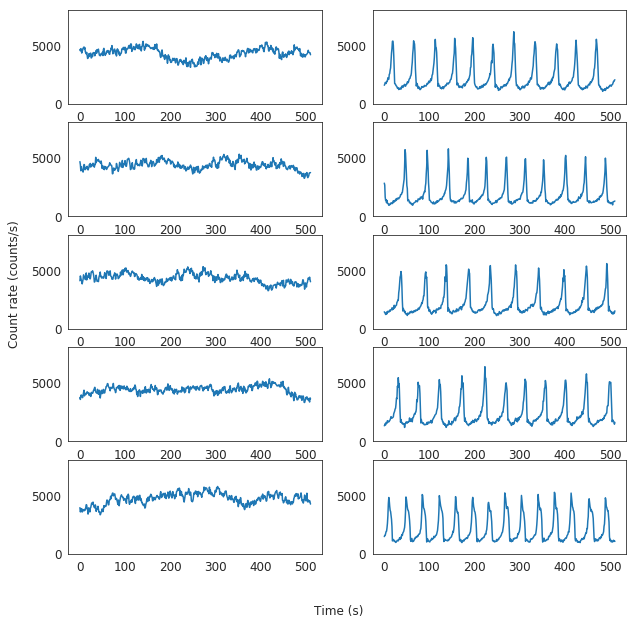

In [68]:
fig, axs = plt.subplots(5, 2)
bottom_rho=bottom_rho.reshape((45,512))
for rho_ind, plot_rho in enumerate(bottom_rho[:5]):
    axs[rho_ind,0].plot(plot_rho)
    axs[rho_ind,0].set_ylim([0,8000])
top_rho=top_rho.reshape((1381,512))
for rho_ind, plot_rho in enumerate(top_rho[:5]):
    axs[rho_ind,1].plot(plot_rho)
    axs[rho_ind,1].set_ylim([0,8000])
    
fig.text(0.5, 0.04, 'Time (s)', ha='center')
fig.text(0.04, 0.5, 'Count rate (counts/s)', va='center', rotation='vertical')
plt.show()

In [93]:
x_ids = np.array(seg_ids)[class_indices]

np.unique(x_ids[class_data[:,1]>0])

array(['20402-01-37-00', '20402-01-38-00', '20402-01-39-00',
       '20402-01-39-02', '20402-01-55-00', '20402-01-57-00',
       '40703-01-13-00'], dtype='<U15')

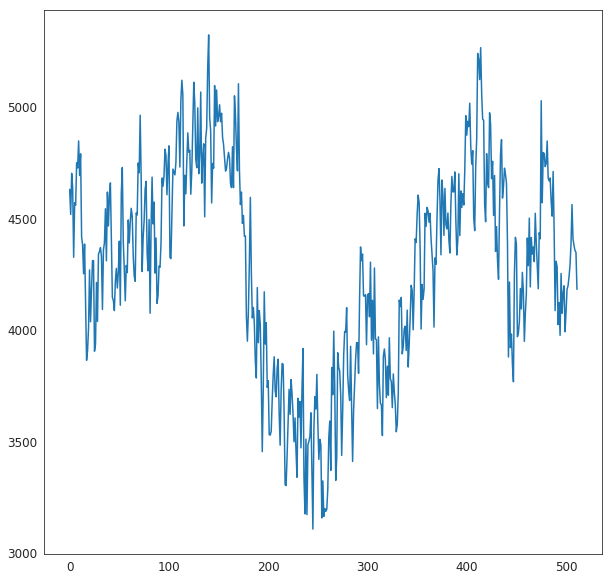

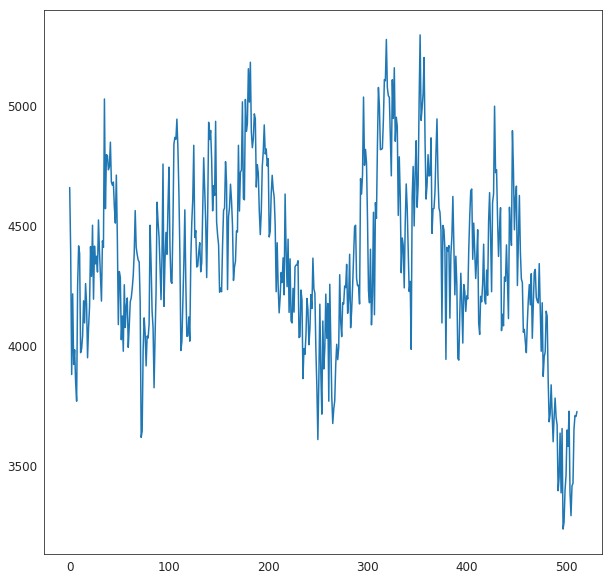

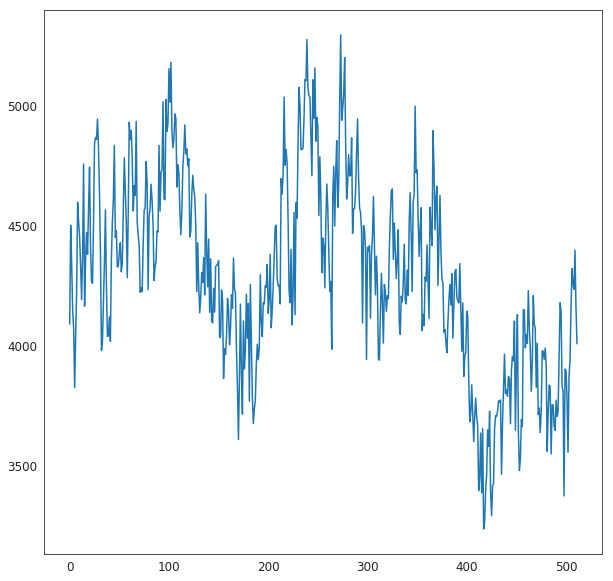

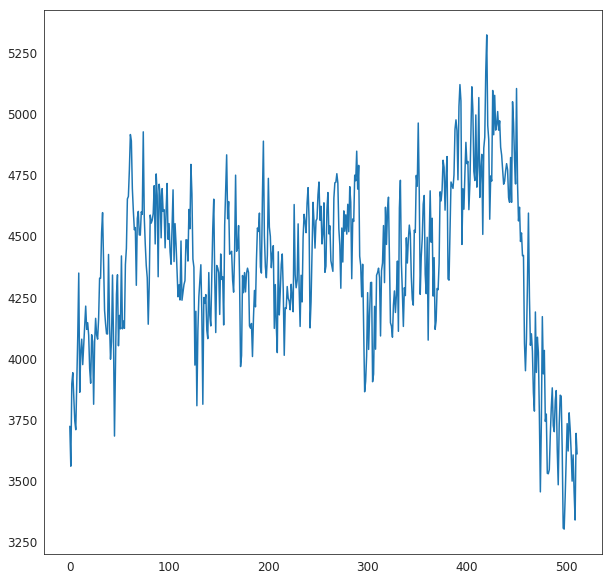

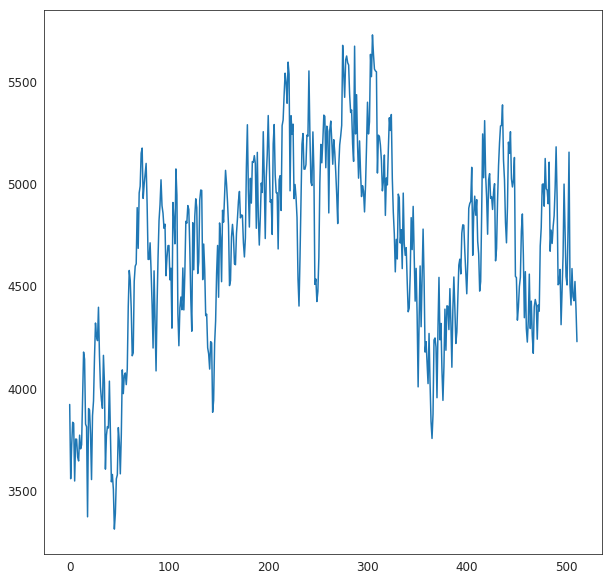

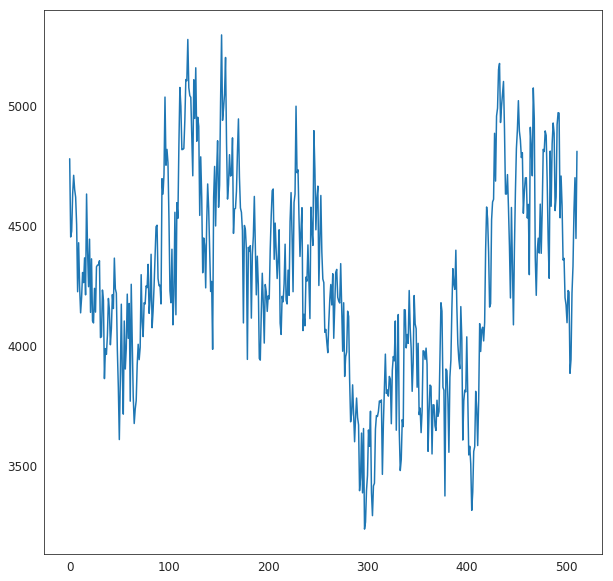

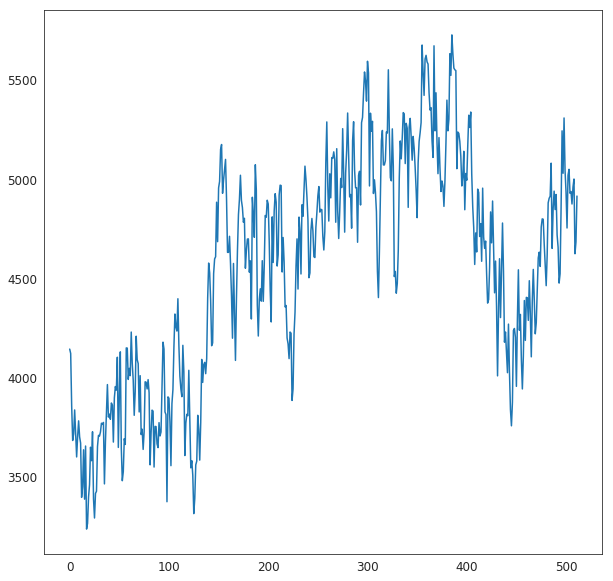

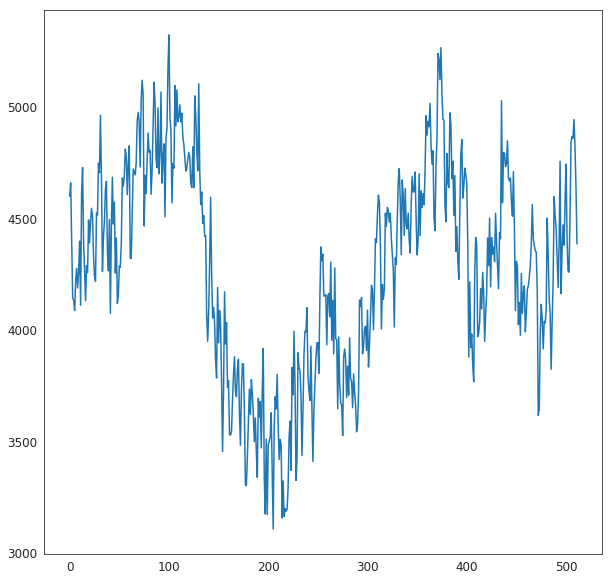

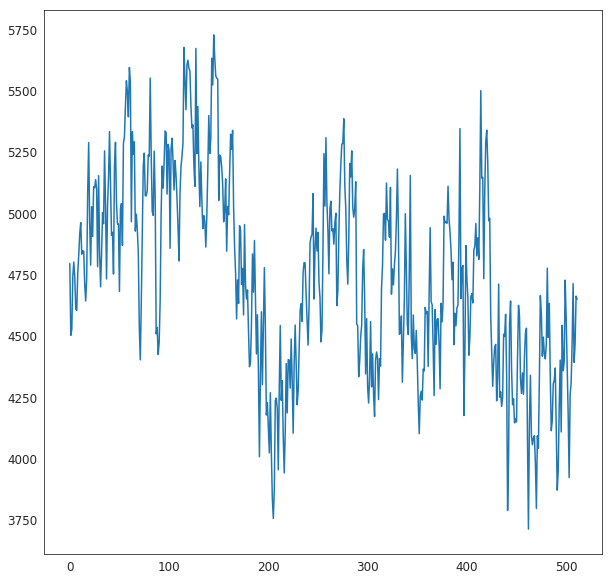

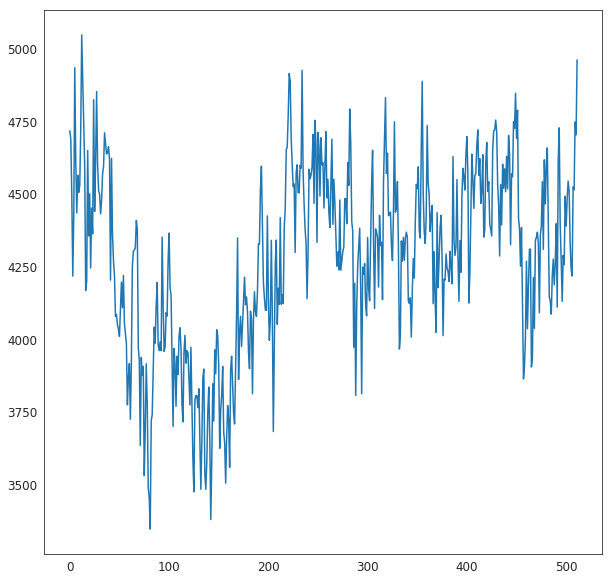

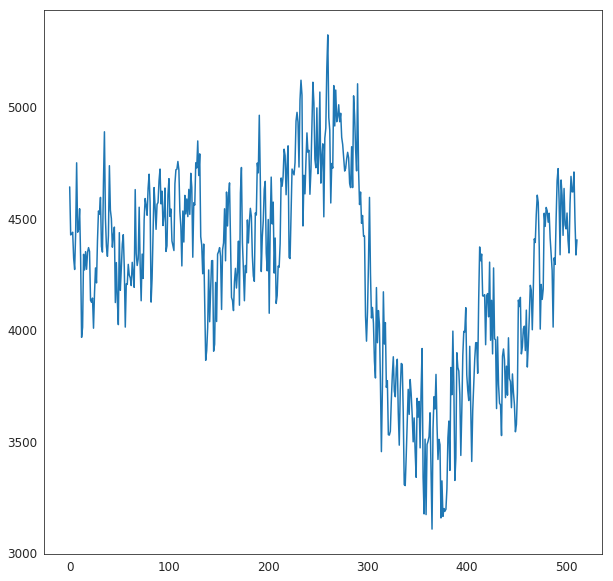

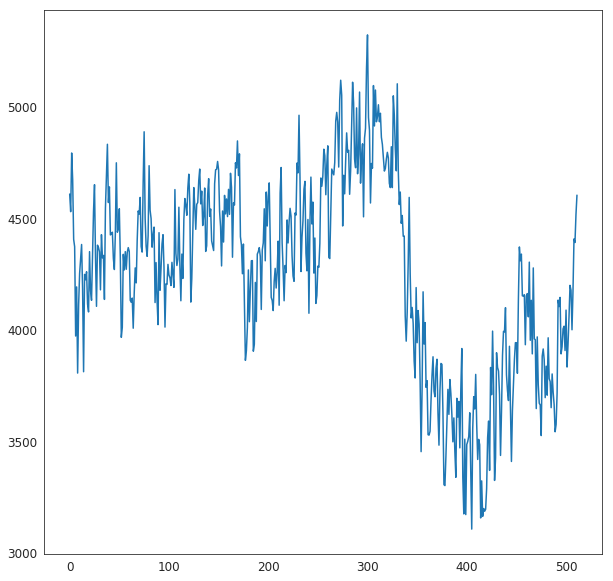

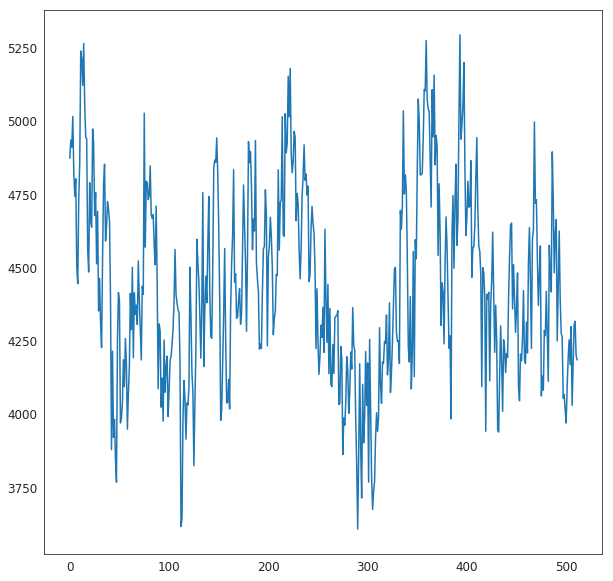

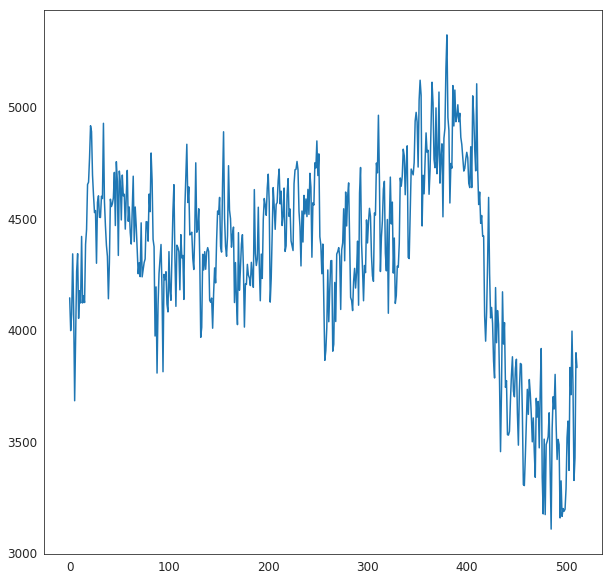

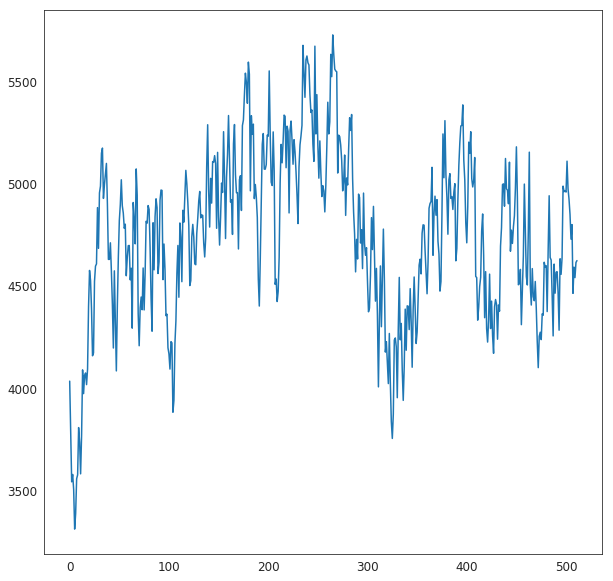

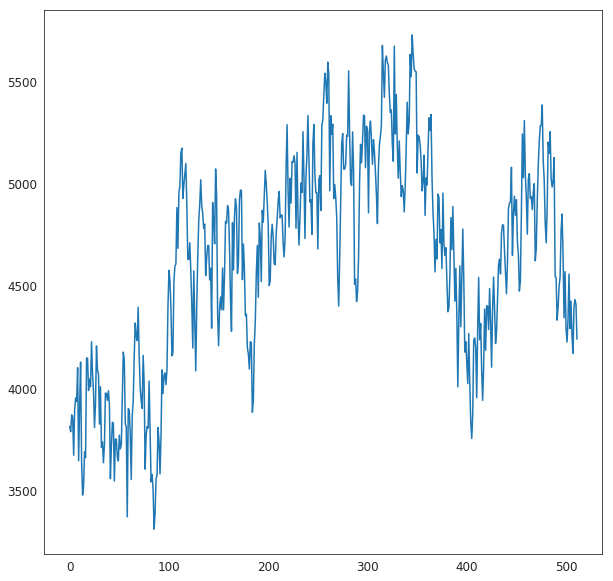

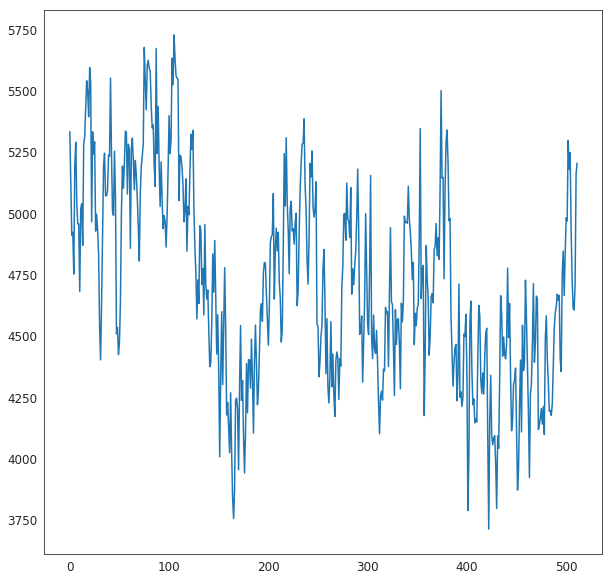

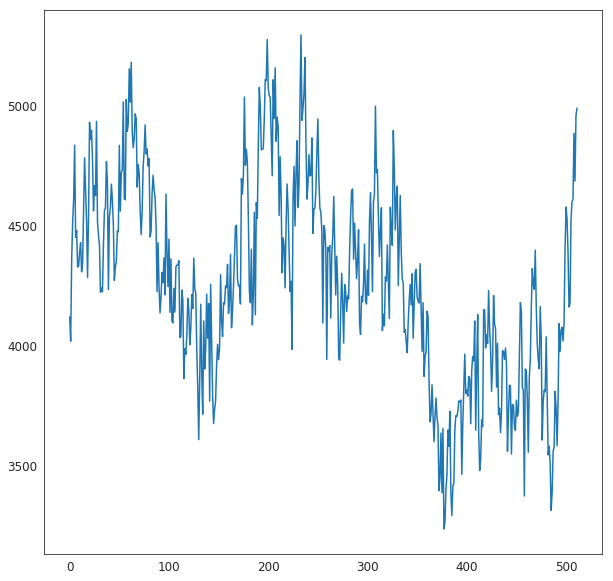

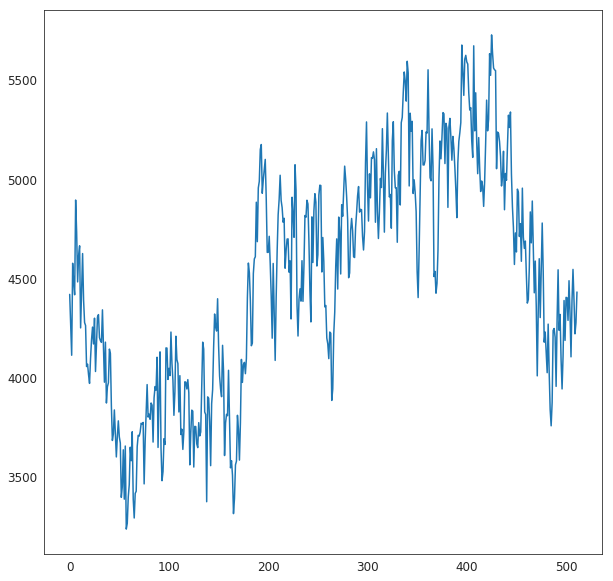

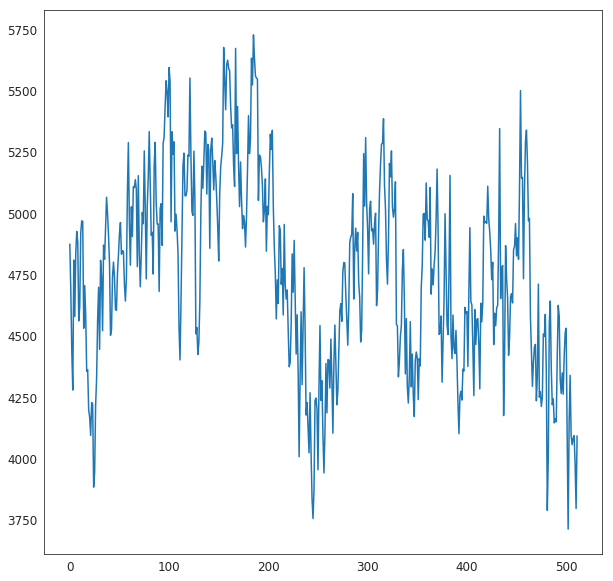

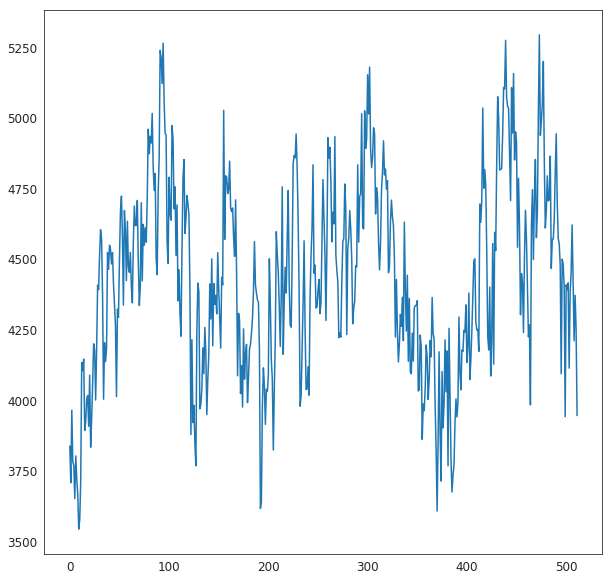

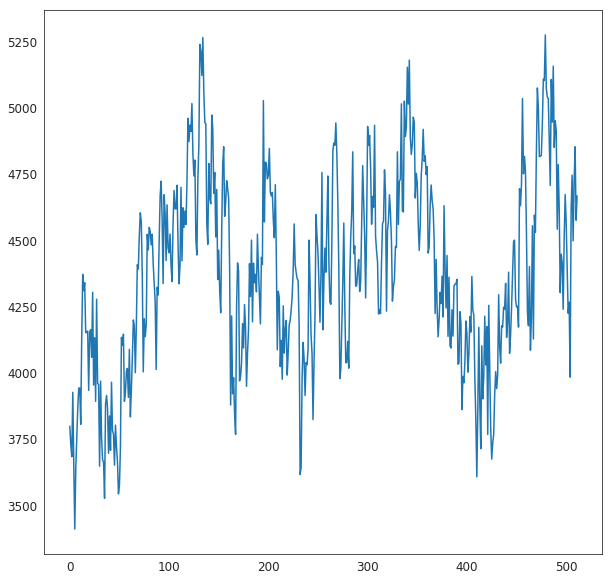

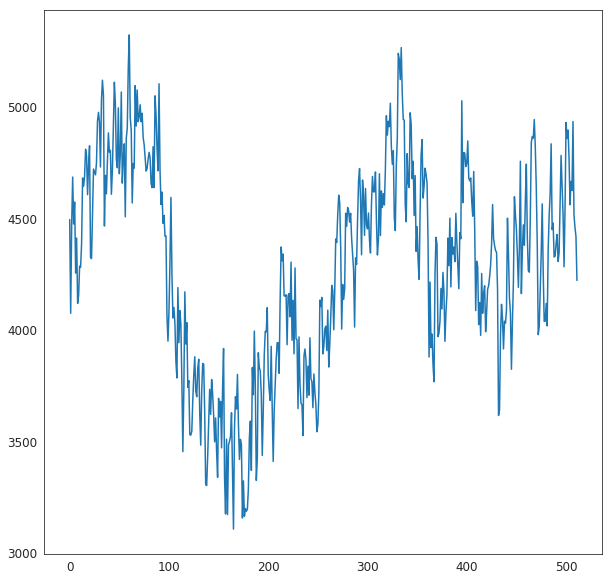

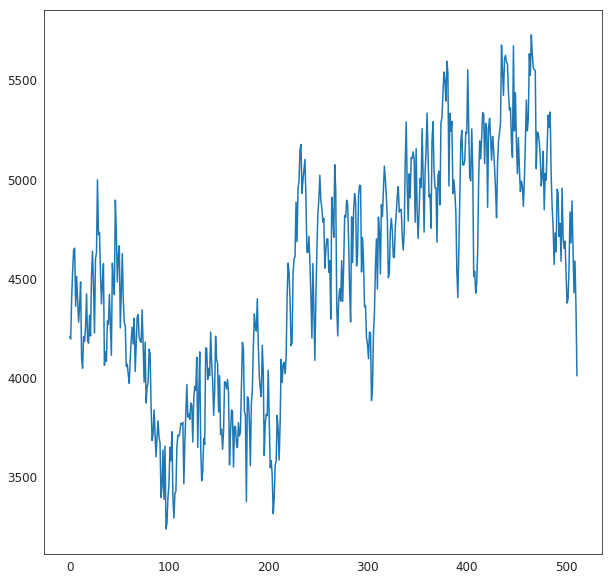

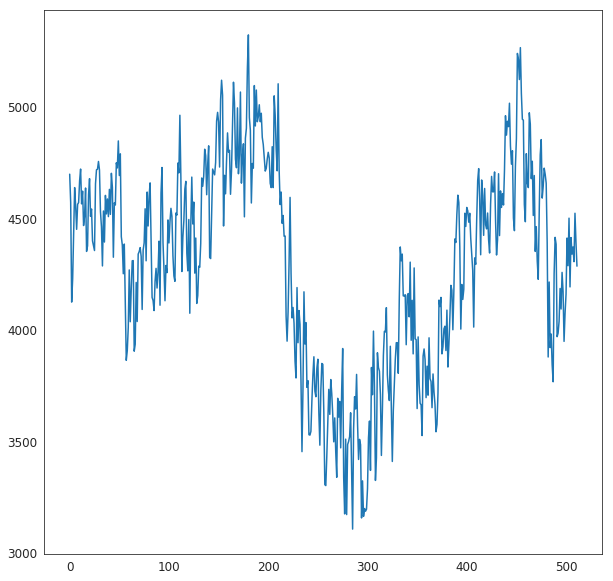

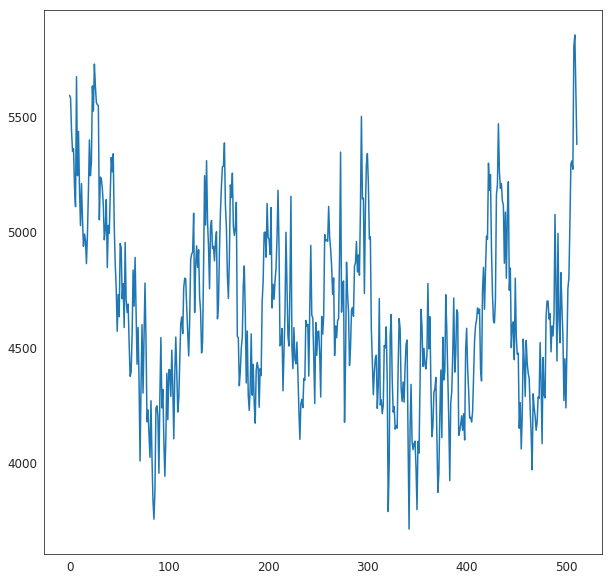

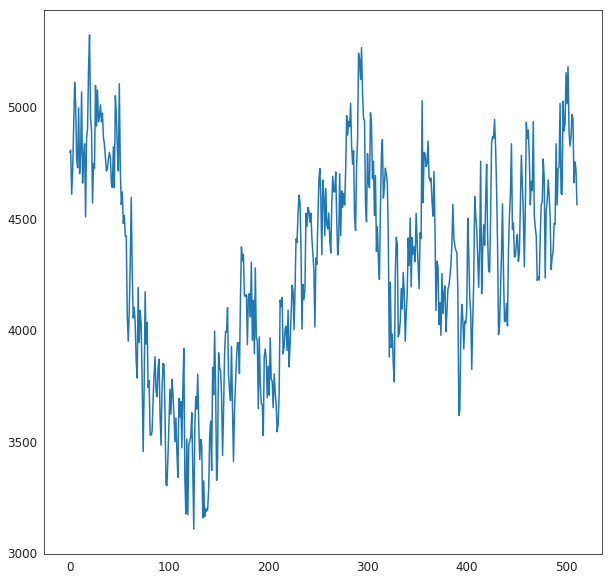

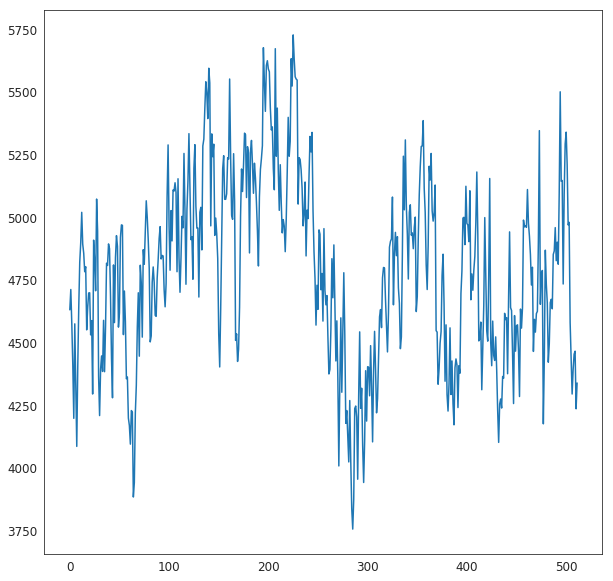

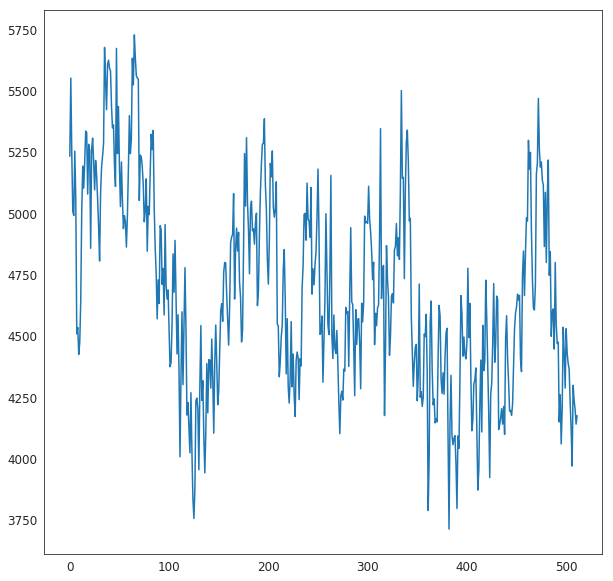

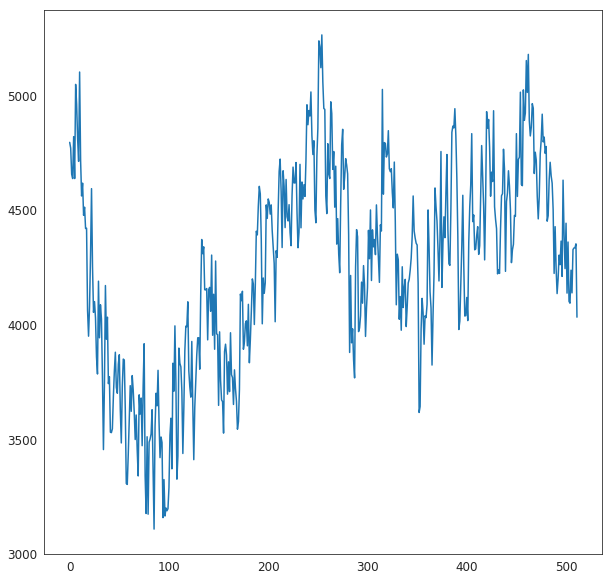

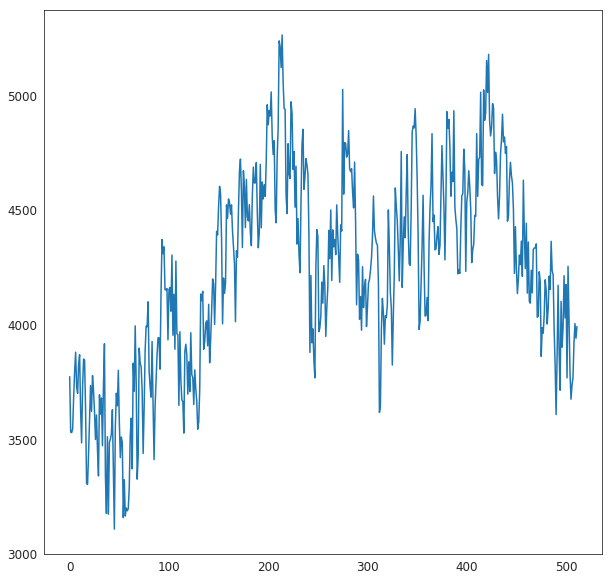

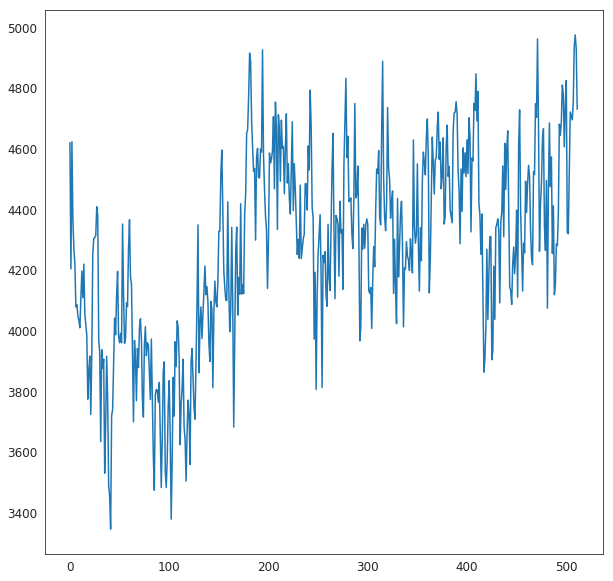

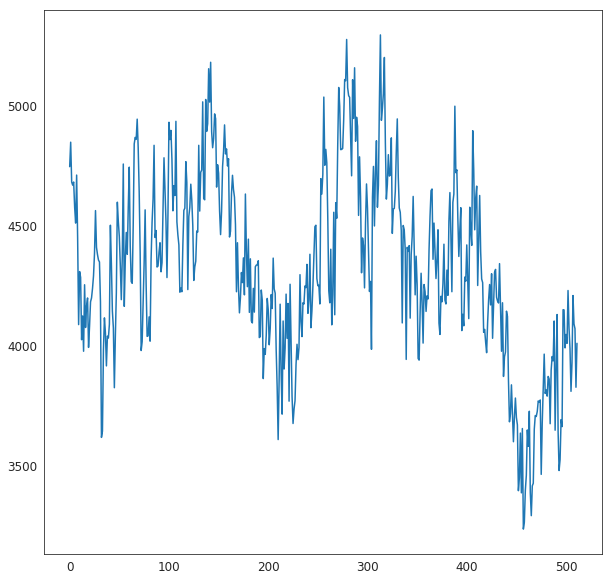

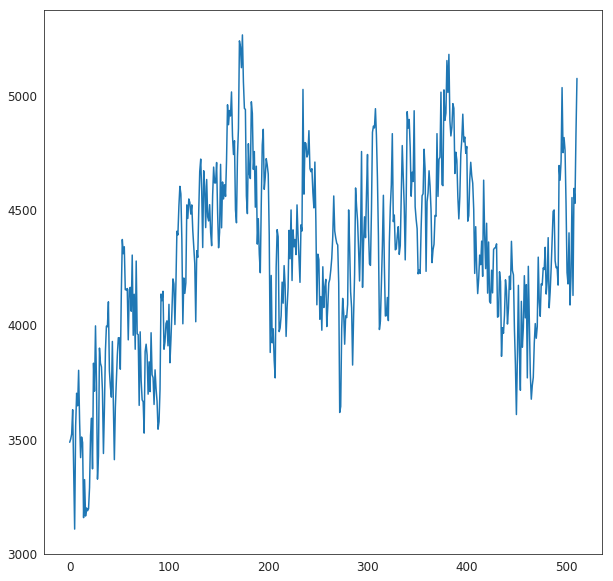

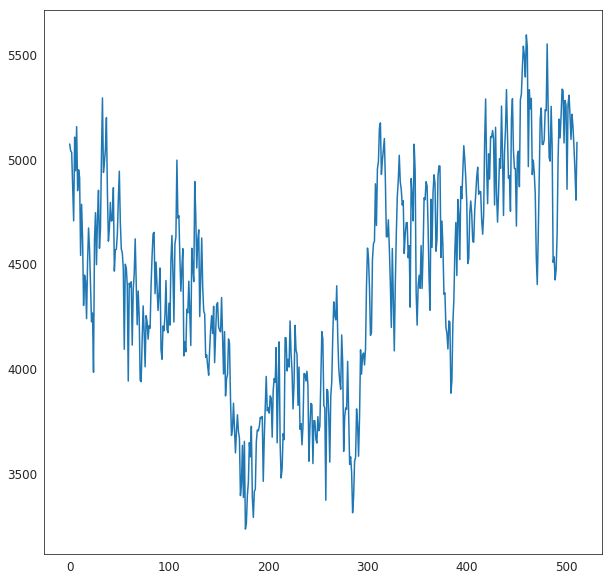

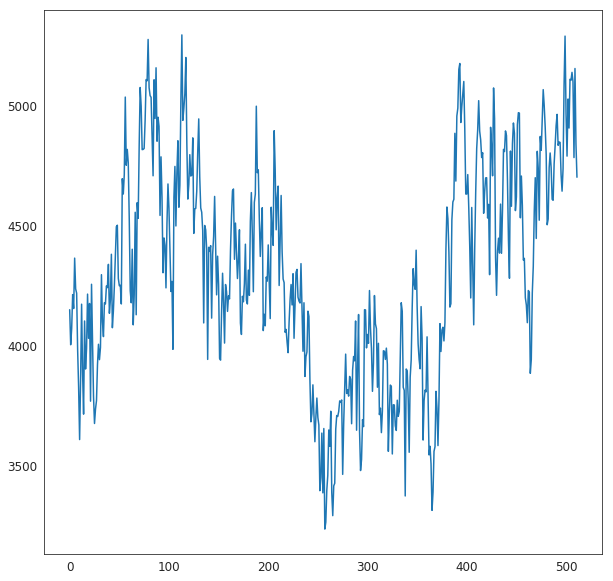

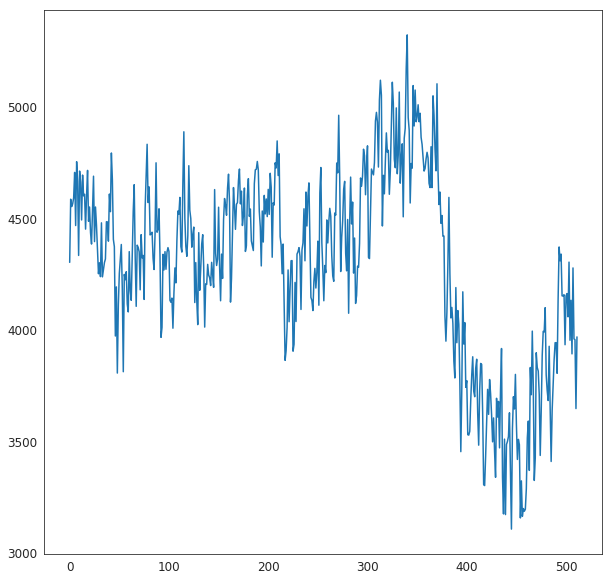

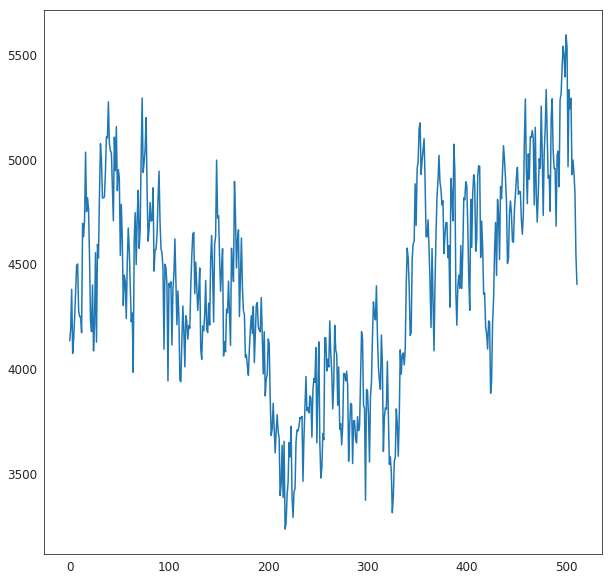

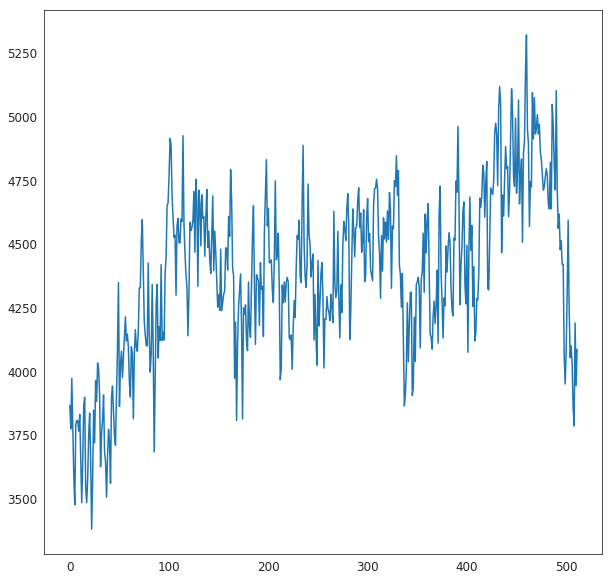

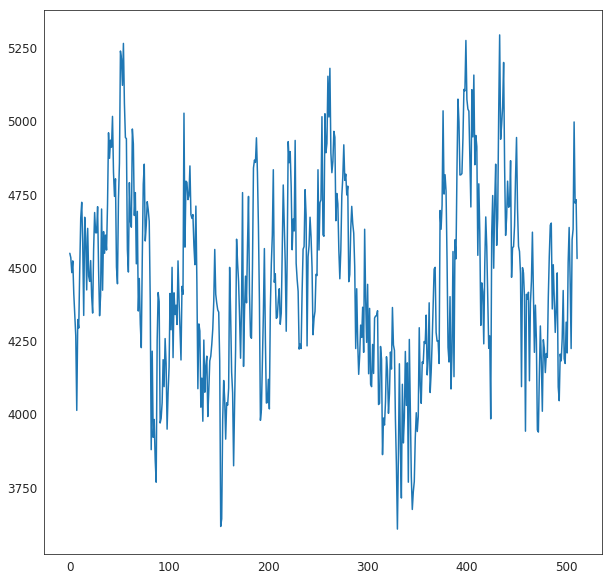

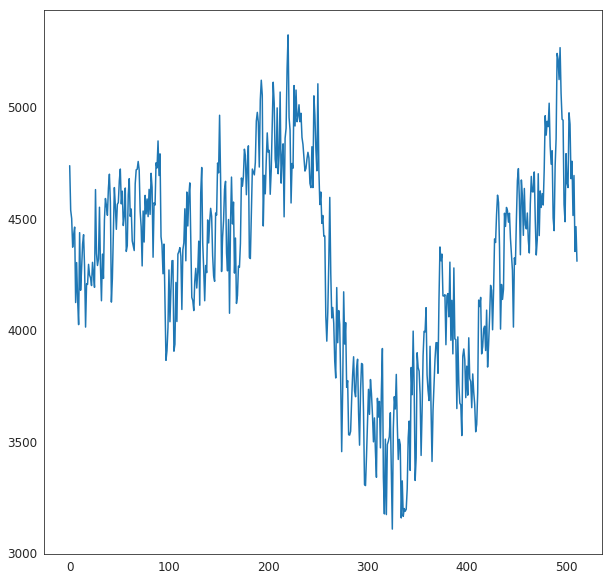

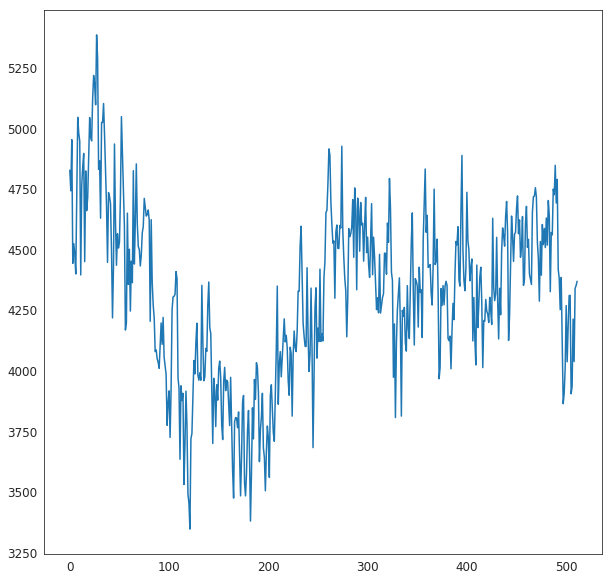

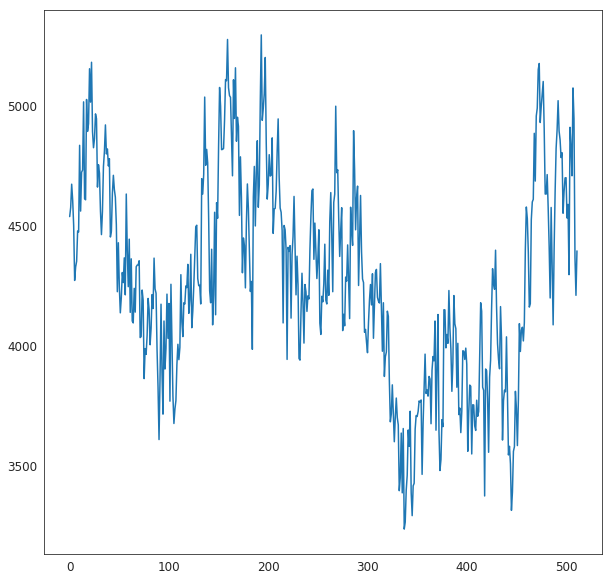

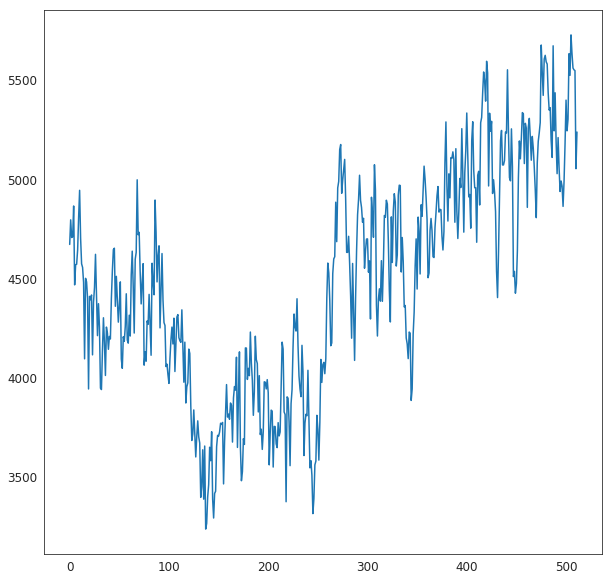

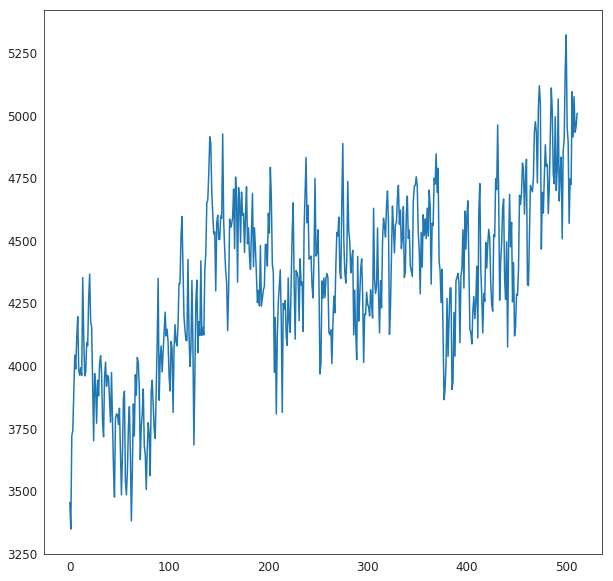

In [58]:
for x in bottom_rho:
    plt.plot(x)
    plt.show()

In [63]:
np.where(np.array(seg_ids) == "20402-01-34-00")[0]

array([  151,  4028,  7989,  8781, 12824, 14986, 16350, 21556, 21580,
       21683, 22222, 24172, 29781, 30446, 31169, 34964, 37336, 43695,
       49545, 50203, 50552, 52073, 52379, 53305, 54224, 56417, 56987,
       63549, 63683, 63900, 64654, 64859, 65058, 68683, 75330, 78667,
       80218, 81070, 82686, 83459, 85579, 85725, 88694, 88783, 89923])

In [65]:
ob_state["20402-01-34-00"]

'rho'

In [78]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams.update({'font.size': 12})
class_indices = np.where(np.array(class_name) == "gamma")
class_data = embeddings_lap[class_indices]
x_segs = segments[class_indices]
top_rho = x_segs[class_data[:,1]>0]
bottom_rho = x_segs[class_data[:,1]<0]


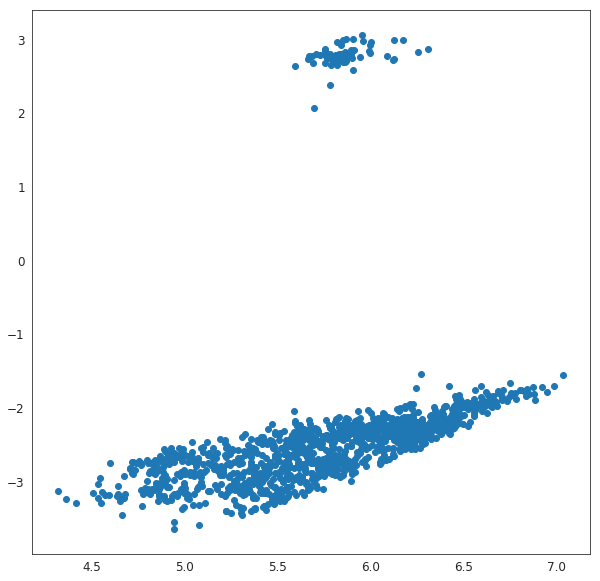

In [70]:
plt.scatter(class_data[:,0], class_data[:,1])
plt.show()

In [72]:
bottom_rho.shape

(1252, 512, 1)

In [88]:
top_rho.shape

(72, 512)

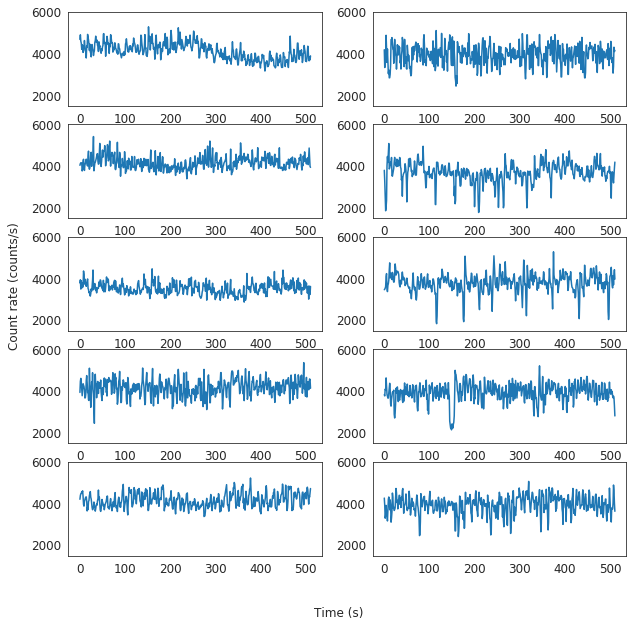

In [91]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

fig, axs = plt.subplots(5, 2)
bottom_rho=np.squeeze(bottom_rho)
for rho_ind, plot_rho in enumerate(bottom_rho[15:20]):
    axs[rho_ind,0].plot(plot_rho)
    axs[rho_ind,0].set_ylim([1500,6000])
top_rho=np.squeeze(top_rho)
for rho_ind, plot_rho in enumerate(top_rho[5:20]):
    axs[rho_ind,1].plot(plot_rho)
    axs[rho_ind,1].set_ylim([1500,6000])
    
fig.text(0.5, 0.04, 'Time (s)', ha='center')
fig.text(0.04, 0.5, 'Count rate (counts/s)', va='center', rotation='vertical')
plt.show()

In [95]:
95921_len512_s40_ids.pkl

{'10258-01-10-00': 'lambda',
 '10408-01-08-00': 'mu',
 '10408-01-09-00': 'phi',
 '10408-01-10-00': 'beta',
 '10408-01-11-00': 'phi',
 '10408-01-12-00': 'phi',
 '10408-01-14-00': 'delta',
 '10408-01-14-01': 'delta',
 '10408-01-14-02': 'delta',
 '10408-01-14-03': 'delta',
 '10408-01-14-04': 'delta',
 '10408-01-14-05': 'delta',
 '10408-01-14-07': 'delta',
 '10408-01-14-08': 'delta',
 '10408-01-14-09': 'delta',
 '10408-01-15-00': 'theta',
 '10408-01-15-01': 'theta',
 '10408-01-15-02': 'theta',
 '10408-01-15-03': 'theta',
 '10408-01-15-04': 'theta',
 '10408-01-15-05': 'theta',
 '10408-01-16-00': 'theta',
 '10408-01-16-01': 'theta',
 '10408-01-16-02': 'theta',
 '10408-01-16-03': 'theta',
 '10408-01-16-04': 'theta',
 '10408-01-17-00': 'delta',
 '10408-01-17-01': 'phi',
 '10408-01-17-02': 'phi',
 '10408-01-17-03': 'delta',
 '10408-01-18-01': 'delta',
 '10408-01-18-04': 'delta',
 '10408-01-19-00': 'phi',
 '10408-01-19-01': 'phi',
 '10408-01-19-02': 'phi',
 '10408-01-20-00': 'phi',
 '10408-01-20